In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Check that we execute with gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(('GPU device not found'))
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Read tagged domains
dom_tagged = pd.read_csv('https://raw.githubusercontent.com/polmoya/tfmUOC/main/clean_data.csv', sep=",")  #Option1 with datasets (phishing + surbl + spam)
#dom_tagged = pd.read_csv('https://raw.githubusercontent.com/polmoya/tfmUOC/main/clean_data_1.csv', sep=",") #Option2 with dataset (malicious mix)

In [4]:
dom_tagged.head()

,dom_name,sld,sld_clean,dangerous
0,google.com,google,##############################################...,0
1,gtld-servers.net,gtld-servers,##############################################...,0
2,youtube.com,youtube,##############################################...,0
3,facebook.com,facebook,##############################################...,0
4,akamaiedge.net,akamaiedge,##############################################...,0


In [5]:
#Onehotencode of an sld
#Input: String, sld
#Output: Tensor with value the one_hot_encode of sld
def onehotencode(sld):
  #Character '#' represents the dummy variable
  alphabets = {'a' : 0, 'b': 1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 'm':12, 'n':13, 'o':14, 
               'p': 15, 'q': 16, 'r':17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 
               '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35, '-': 36, '#': 37}
  idxs = [alphabets[ch] for ch in sld]
  return tf.one_hot(idxs, 37, dtype=tf.float16)

In [6]:
#Funcio realitza el one_hot_encode de la llista de slds.
#One_hot_encode of the slds from a dataframe
#Input: dataframe
#Output: Column 'sld_one_hot' added to dataframe
def onehotencode_column(df):
  #Extract list of sld_clean
  sld = df['sld_clean'].values.tolist()
  one_hot_sld = []
  for x in sld:
    one_hot_sld.append(onehotencode(x))
  #Add to dataframe the sld_clean values one_hot_encoded
  df['sld_one_hot'] = one_hot_sld

In [7]:
onehotencode_column(dom_tagged)

In [8]:
dom_tagged.head()

,dom_name,sld,sld_clean,dangerous,sld_one_hot
0,google.com,google,##############################################...,0,"((tf.Tensor(0.0, shape=(), dtype=float16), tf...."
1,gtld-servers.net,gtld-servers,##############################################...,0,"((tf.Tensor(0.0, shape=(), dtype=float16), tf...."
2,youtube.com,youtube,##############################################...,0,"((tf.Tensor(0.0, shape=(), dtype=float16), tf...."
3,facebook.com,facebook,##############################################...,0,"((tf.Tensor(0.0, shape=(), dtype=float16), tf...."
4,akamaiedge.net,akamaiedge,##############################################...,0,"((tf.Tensor(0.0, shape=(), dtype=float16), tf...."


In [9]:
#Assign variables train_X and train_Y for the model
train_X = tf.stack(values=(dom_tagged['sld_one_hot']), axis=0)
train_Y = tf.convert_to_tensor(dom_tagged["dangerous"], dtype=tf.float16)

In [10]:
#Check structure of dataset
print('Training data shape : ', train_X.shape, train_Y.shape, train_X[0].shape)

Training data shape :  (574628, 63, 37) (574628,) (63, 37)


In [11]:
#https://www.anycodings.com/1questions/2398077/how-to-perform-sklearn-style-train-test-split-on-feature-and-label-tensors-using-built-in-tensorflow-methods
#Function to create train, val and tests partitions with tensors.
from typing import Tuple

def split_train_test(features: tf.Tensor,
                     labels: tf.Tensor,
                     test_size: float,
                     random_state: int = 1729) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:

    # Generate random masks
    random = tf.random.uniform(shape=(tf.shape(features)[0],), seed=random_state)
    train_mask = random >= test_size
    test_mask = random < test_size

    # Gather values
    train_features, train_labels = tf.boolean_mask(features, mask=train_mask), tf.boolean_mask(labels, mask=train_mask)
    test_features, test_labels = tf.boolean_mask(features, mask=test_mask), tf.boolean_mask(labels, mask=test_mask)

    return train_features, test_features, train_labels, test_labels

In [12]:
#Create training and test model partitions
train_X, test_X, train_Y,  test_Y = split_train_test(train_X, train_Y, test_size=0.2, random_state=13)

In [13]:
#Check shape again
print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(459600, 63, 37) (115028, 63, 37) (459600,) (115028,)


In [14]:
import keras
from keras.models import Sequential,Model
from keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D

In [15]:
model = Sequential()
model.add(Conv1D(50, 5, activation='relu', input_shape=(63,37)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 50)            9300      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 50)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1450)              0         
                                                                 
 dense (Dense)               (None, 30)                43530     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                        

In [17]:
#Compile CNN
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
#Train model
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=10, batch_size=64)

Epoch 1/10
7182/7182 [==============================] - 39s 4ms/step - loss: 0.2939 - accuracy: 0.8714 - val_loss: 0.2650 - val_accuracy: 0.8836
Epoch 2/10
7182/7182 [==============================] - 31s 4ms/step - loss: 0.2537 - accuracy: 0.8906 - val_loss: 0.2507 - val_accuracy: 0.8917
Epoch 3/10
7182/7182 [==============================] - 30s 4ms/step - loss: 0.2431 - accuracy: 0.8954 - val_loss: 0.2479 - val_accuracy: 0.8933
Epoch 4/10
7182/7182 [==============================] - 30s 4ms/step - loss: 0.2366 - accuracy: 0.8985 - val_loss: 0.2455 - val_accuracy: 0.8943
Epoch 5/10
7182/7182 [==============================] - 29s 4ms/step - loss: 0.2315 - accuracy: 0.9011 - val_loss: 0.2468 - val_accuracy: 0.8947
Epoch 6/10
7182/7182 [==============================] - 29s 4ms/step - loss: 0.2278 - accuracy: 0.9027 - val_loss: 0.2449 - val_accuracy: 0.8953
Epoch 7/10
7182/7182 [==============================] - 29s 4ms/step - loss: 0.2247 - accuracy: 0.9043 - val_loss: 0.2448 - val_ac

29s 4ms/step - loss: 0.2013 - accuracy: 0.9162 - val_loss: 0.2607 - val_accuracy: 0.8930

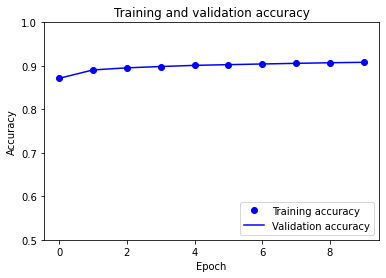

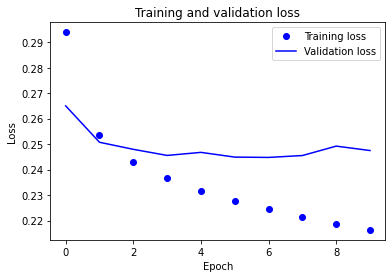

3595/3595 [==============================] - 10s 3ms/step - loss: 0.2475 - accuracy: 0.8951
Test loss: 0.24747614562511444
Test accuracy: 0.8951298594474792


In [19]:
#Plot accuracy and validation loss of the model
accuracy = history.history['accuracy']
val_accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_eval = model.evaluate(test_X, test_Y, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [20]:
#Save model
model.save('model1')

In [26]:
#Shell comand to get newly registered domains and safe them on a zip with yesterday date
%%shell
datedl=$(date --date '1 days ago' '+%Y-%m-%d')
zip="$datedl.zip"
b64=$(echo $zip | base64)

ok=$(expr $b64 : "\(.*\).$")

urlbase="https://whoisds.com//whois-database/newly-registered-domains/"
urlend="=/nrd"

allurl="$urlbase$ok$urlend"

wget -O $zip $allurl

--2022-11-18 16:27:18--  https://whoisds.com//whois-database/newly-registered-domains/MjAyMi0xMS0xNi56aXA=/nrd
Resolving whoisds.com (whoisds.com)... 103.242.119.24
Connecting to whoisds.com (whoisds.com)|103.242.119.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834438 (815K) [application/octet-stream]
Saving to: ‘2022-11-16.zip’

2022-11-16.zip      100%[===================>] 814.88K   965KB/s    in 0.8s    

2022-11-18 16:27:20 (965 KB/s) - ‘2022-11-16.zip’ saved [834438/834438]



In [22]:
#Function to split the domain, into tld, sld and third. Also preprocess dataset
#Input: dataframe
#Output: dataframe (clean)
def split_clean_domain(data):
  #Add '.' if there's only one '.'. To avoid errors at spliting sld.
  data['dom_name_aux'] = data.dom_name.apply(lambda x: '.' + x if len(re.findall('[.]', x)) <= 1 else x)
  #Split domain into tld, sld and thirdld
  data[['sld', 'tld']] = data['dom_name_aux'].str.rsplit('.', 1, expand=True)
  data[['thirdld', 'sld']] = data['sld'].str.split('.', 1, expand=True)
  data.loc[data['sld'].isnull(), 'aux'] = data['thirdld']
  data.loc[data['sld'].isnull(), 'thirdld'] = data['sld']
  data.loc[data['sld'].isnull(), 'sld'] = data['aux']
  data['sld'] = data['sld'].str.lower()
  #Clean sld for the one_hot_encoding
  data['sld_clean'] = data['sld'].str.replace(r'[^-0-9a-zA-Z]', '#', regex=True)
  data['sld_clean'] = data['sld_clean'].str.pad(63, side='left', fillchar='#')
  #Delete not needed columns
  data.pop('dom_name_aux')
  data.pop('aux')
  data.pop('thirdld')
  data.pop('tld')
  #Delete rows with sld not valid
  data = data[data['sld_clean'].str.len() <= 63]
  return

In [28]:
#Read newly registered domains
from datetime import datetime, timedelta
yesterday = datetime.now() - timedelta(1)
zip_name = datetime.strftime(yesterday, '%Y-%m-%d') + '.zip'
print(zip_name)
#Read recent_domains
dom_recent = pd.read_csv(zip_name, sep=" ", header=None, nrows=50000)
dom_recent.columns = ["dom_name"]
#Clean recent domains
split_clean_domain(dom_recent)
dom_recent = dom_recent[dom_recent['sld_clean'].str.len() <= 63] #delete slds > 63
dom_recent.head()

2022-11-16.zip


,dom_name,sld,sld_clean
0,1688-0.top,1688-0,##############################################...
1,2323433351.xyz,2323433351,##############################################...
2,4nita.tech,4nita,##############################################...
3,787betturkey.com,787betturkey,##############################################...
4,9000657643.xyz,9000657643,##############################################...


In [29]:
#One hot encode for prediction recent domains
onehotencode_column(dom_recent)
pred_X = tf.stack(values=(dom_recent['sld_one_hot']), axis=0)

In [30]:
#Prediction
pred = model.predict(pred_X, batch_size=32)
#Assign prediction to the dataframe
dom_recent['dangerous(%)'] = pred[:,1]*100

1563/1563 [==============================] - 3s 2ms/step


In [31]:
dom_recent.head()

,dom_name,sld,sld_clean,sld_one_hot,dangerous(%)
0,1688-0.top,1688-0,##############################################...,"((tf.Tensor(0.0, shape=(), dtype=float16), tf....",92.973213
1,2323433351.xyz,2323433351,##############################################...,"((tf.Tensor(0.0, shape=(), dtype=float16), tf....",97.139908
2,4nita.tech,4nita,##############################################...,"((tf.Tensor(0.0, shape=(), dtype=float16), tf....",56.633038
3,787betturkey.com,787betturkey,##############################################...,"((tf.Tensor(0.0, shape=(), dtype=float16), tf....",88.693504
4,9000657643.xyz,9000657643,##############################################...,"((tf.Tensor(0.0, shape=(), dtype=float16), tf....",99.799171


In [32]:
#Save as csv the predictions of the most recent domains registered.
dom_recent[['dom_name', 'sld', 'dangerous(%)']].to_csv("recent_domains_prediction.csv", index=False)

In [33]:
#Function to predict the % for a list of domains to be dangerous.
#Input: domains: list of domains, model: trained model
#Output: dataframe with 3 columns: dom_name, sld, % dangerous (dangerous(%))
def domain_prediction(domains, model):
  df = pd.DataFrame(data=domains, columns=['dom_name'])
  split_clean_domain(df)
  onehotencode_column(df)
  pred = model.predict(tf.stack(values=(df['sld_one_hot']), axis=0), batch_size=32)
  df.pop('sld_clean')
  df.pop('sld_one_hot')
  df['dangerous(%)'] = pred[:,1]*100
  return df

In [34]:
#Personalized prediction: Assign a domain name or array of domains to dom_pred
dom_pred = ["google.com", "go0gle.com", "https://www.uoc.edu/", "netflix.com", "primevideo.com", "adams.wada-ama.org", "connect.garmin.com", "web.whatsapp.com",
            "1688.com", "naohvspwc.info", "vboypro16.firebaseapp.com", "vote-academymoderators.com", "web-online-sup.com"]
df_pred = domain_prediction(dom_pred, model)
df_pred.head(20)

1/1 [==============================] - 0s 32ms/step


,dom_name,sld,dangerous(%)
0,google.com,google,4.205112
1,go0gle.com,go0gle,9.162738
2,https://www.uoc.edu/,uoc,0.228243
3,netflix.com,netflix,3.558344
4,primevideo.com,primevideo,0.566379
5,adams.wada-ama.org,wada-ama,1.655113
6,connect.garmin.com,garmin,1.855898
7,web.whatsapp.com,whatsapp,2.136443
8,1688.com,1688,38.339458
9,naohvspwc.info,naohvspwc,99.056740


In [35]:
#Tests:
#Train model
#model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=20, batch_size=32)

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
https://www.analyticsvidhya.com/blog/2021/08/beginners-guide-to-convolutional-neural-network-with-implementation-in-python/
https://pub.towardsai.net/convolutional-neural-networks-cnns-tutorial-with-python-417c29f0403f
https://www.tensorflow.org/tutorials/images/cnn
https://www.datacamp.com/blog/keras-cheat-sheet-neural-networks-in-python
https://www.tensorflow.org/text/guide/word_embeddings
https://www.kaggle.com/code/kawiswara/malicious-web-detection-with-1d-cnn#Create-CNN-Model
https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39